# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 4 — Gaussians

---

Submission by:
* Sam, Laing, Matrikelnummer: 6283670
* Albert, Catalan Tatjer, Matrikelnummer:6443478

In [3]:
import jax.numpy as jnp
from jax import random
key = random.PRNGKey(0)
from exponential_families import *
from tueplots import bundles
from matplotlib import pyplot as plt
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Exercise 4.2 (Coding Exercise)

> This week's Exercise is directly taken from Exercise 24.3. of [David JC MacKay](https://en.wikipedia.org/wiki/David_J._C._MacKay)'s [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/). (But don't waste your time trying to find an answer there :)

The terribly important quantity $\mu$ has been experimentally measured by seven scientists (A, B, C, D, E, F, G) with wildly differing experimental skills. They have reported the following measurements:

In [4]:
X = jnp.array([-27.020,3.570,8.191,9.898,9.603,9.945,10.056])

Text(0.5, 0, 'measured value of $x$')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


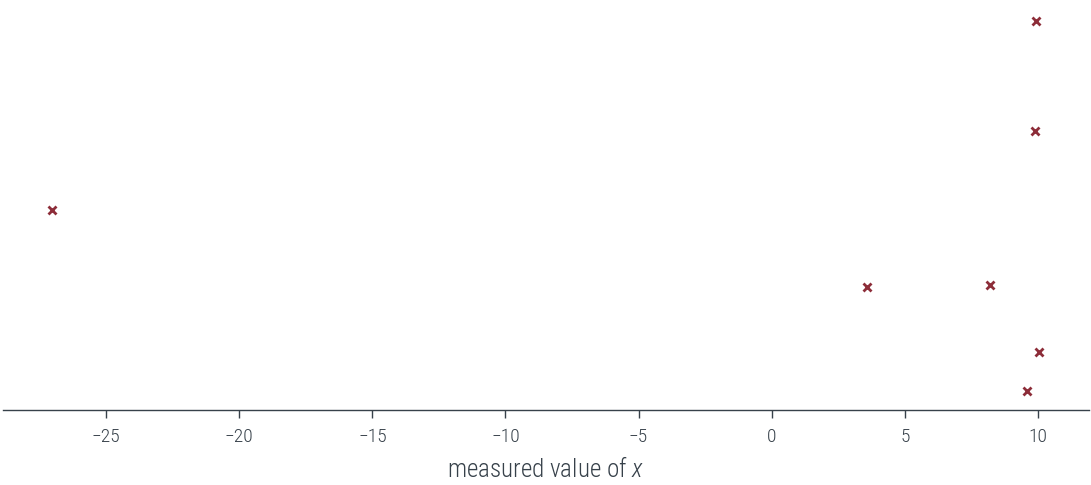

In [5]:
fig,ax = plt.subplots(1,1)
ax.plot(X,random.uniform(key, shape=(7,)),'x',ms=3)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('measured value of $x$')

We assume that they have all, independently of each other, made an unbiased Gaussian measurement of $\mu$: 
$$p(\boldsymbol{x}\mid \mu,\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{N}(x_i;\mu,\sigma_i ^2).$$ 
But we have to assume that their measurement errors $\sigma_i$ vary a lot (some are skilled experimentalists, others are unqualified). 

#### Task A: 
Implement the likelihood above as a single jax function (this is unfortunately a case where our neat `ExponentialFamily` base class is more awkward than useful). Try using a numerical optimizer to find *maximum likelihood estimators*, i.e. points $(\mu, \vec{\sigma})$ that maximize this function. Alternatively, you can try and identify such points directly by inspecting the likelihood by hand.
  
You probably agree that, intuitively, it looks pretty certain that A and B are both inept measurers, that D–G are better, and that the true value of $\mu$ is somewhere close to $10$. Are your findings consistent with this intuition?  

The Likelihood here is given by
$$
L(\mu, \sigma_1,...,\sigma_7) = \prod_{j=1}^{7} {\frac{1}{\sqrt{2\pi}\sigma_j} \ \exp(-\frac{1}{2} \frac{(x_j - \mu)^2}{\sigma_j^2})}
$$
So the Log-likelihood is therefore given by:
$$
\log \ L = -7 \log(\sqrt{2\pi}) - \sum_{j=1}^7 \log(\sigma_j) - \frac{1}{2} \sum_{j=1}^7 \frac{(x_j - \mu)^2}{2\sigma_j^2} 
$$
We implement this function in jax and then optimize by minimizing the negative log likelihood over $(\mu, \sigma_1,...,\sigma_7)$

In [6]:
from jax.scipy.optimize import minimize

params_init = jnp.array([10, 1, 1, 1, 1, 1, 1, 1])


# defining the negative log likelihood 
# (including the square root of a square to ensure positive values for the standard deviations)
# also leaving out the constant since it doesn't affect the optimization
def neg_log_like(params):
    mu, sig = params[0], params[1:]
    return jnp.sum(jnp.log(jnp.sqrt(sig)) ** 2 + 0.5 * ((X - mu) / sig) ** 2)

In [9]:
# minimizing using jax and initializing with higher variance for samples far away from
result = minimize(
    neg_log_like, x0=jnp.array([10, 40, 15, 2, 0.5, 0.5, 0.5, 0.25]), method="BFGS"
)

# Extract the optimized parameters and the minimum value
params_optimized = result.x



In [10]:
p_optim = [params_optimized[0]]
p_optim.extend(jnp.sqrt(s) for s in params_optimized[1:])
print("Optimized Parameters:", p_optim)

Optimized Parameters: [Array(9.722158, dtype=float32), Array(5.3295555, dtype=float32), Array(2.5276077, dtype=float32), Array(1.5314531, dtype=float32), Array(1.0280777, dtype=float32), Array(1.0135379, dtype=float32), Array(1.0428718, dtype=float32), Array(1.084028, dtype=float32)]


Our findings seem to agree with $\mu$ being close to 10 and the variance of the leftmost and second leftmost observers being much higher than the ones close to 10.
However, in order to arrive at the "correct" local minima, we had to initialize the variance $\sigma_1$ to be fairly high which is reasonable since otherwise we may find other local minima in this 8 dimensional function.

#### Task B:
We will now instead provide a Bayesian answer. Let the prior on each $\sigma_i^{-2}$ be a broad [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), i.e. the distribution
$$ \mathcal{G}(z;\alpha,\beta)=\frac{\beta^\alpha}{\Gamma(\alpha)} z^{\alpha-1} e^{-\beta z},$$
and
$$p(\boldsymbol{\sigma}) = \prod_{i=1} ^7 \mathcal{G}(\sigma_i^{-2};\alpha,\beta),$$ 
with, say, $\alpha=1$, $\beta=0.1$. 

Let the prior for $\mu$ be a broad Gaussian $p(\mu) = \mathcal{N}(\mu; m, v^2)$ with mean $m = 0$ and standard deviation $v = 10^3$. 

Find the posterior for $\mu$. Plot this posterior for $\mu$, both for the data given above and for $\boldsymbol{x} = \{13.01, 7.39\}$.


**Hint:** First, remember that the Gamma is the conjugate prior for the Gaussian with fixed mean $\mu$. The marginal $p(\boldsymbol{x}\mid\mu)$ can thus be computed using the `log_marginal_pdf` function you implemented generically for exponential families last week, and which has an analytic form. Then use Bayes' theorem a second time to find $p(\mu\mid\boldsymbol{x})$ up to normalization, by directly multiplying the prior for $\mu$ and the marginal likelihood terms you just found. 


We observe that we have:
$$
\int_0^{\infty} z^{a-1}e^{-bz} dz = \frac{\Gamma(a)}{b^a}
$$

In [12]:
import abc
import functools


class ExponentialFamily(abc.ABC):
    @abc.abstractmethod
    def sufficient_statistics(self, x: ArrayLike, /) -> jnp.ndarray:
        """Signature `(D)->(P)`"""

    @abc.abstractmethod
    def log_base_measure(self, x: ArrayLike, /) -> jnp.ndarray:
        """Signature `(D)->()`"""

    @abc.abstractmethod
    def log_partition(self, parameters: ArrayLike, /) -> jnp.ndarray:
        """Signature `(P)->()`"""

    def parameters_to_natural_parameters(self, parameters: ArrayLike, /) -> jnp.ndarray:
        """Signature `(P)->(P)`
        In some EF's, the canonical parameters are
        actually a transformation of the natural parameters.
        In such cases, this method should be overwritten to
        provide the inverse transformation.
        """
        return jnp.asarray(parameters)

    def logpdf(self, x: ArrayLike, parameters: ArrayLike, /) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        log p(x|parameters)
            = log h(x) + sufficient_statistics(x) @ natural_parameters - log Z(natural_parameters)
            = log base measure + linear term - log partition
        """

        x = jnp.asarray(x)
        log_base_measure = self.log_base_measure(x)
        natural_parameters = self.parameters_to_natural_parameters(parameters)
        linear_term = (
            self.sufficient_statistics(x)[..., None, :] @ natural_parameters[..., None]
        )[..., 0, 0]
        log_partition = self.log_partition(parameters)

        return log_base_measure + linear_term - log_partition

    def conjugate_log_partition(
        self, alpha: ArrayLike, nu: ArrayLike, /
    ) -> jnp.ndarray:
        """The log partition function of the conjugate exponential family.
        Signature `(P),()->()`
        If(!) this is available, it allows analytic construction of the conjugate prior (and thus analytic posterior inference).
        """
        raise NotImplementedError()

    def conjugate_prior(self) -> "ConjugateFamily":
        return ConjugateFamily(self)

    def predictive_log_marginal_pdf(
        self,
        x: ArrayLike,
        conjugate_natural_parameters: ArrayLike,
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        log p(x|conjugate_natural_parameters)
        Your answer to Part B below should be implemented here.
        """
        x = jnp.asarray(x)
        alpha, nu = conjugate_natural_parameters
        P = (
            self.log_base_measure(x)
            + self.conjugate_log_partition(
                self.sufficient_statistics(x) + alpha, nu + 1
            )
            - self.conjugate_log_partition(alpha, nu)
        )

        return P[0][0], P[1][0]


    def posterior_parameters(
        self,
        prior_natural_parameters: ArrayLike,
        data: ArrayLike,
    ) -> jnp.ndarray:
        """Computes the natural parameters of the posterior distribution under the
        conjugate prior.
        Signature `(P),(D)->(P)`
        This can be implemented already in the abc and inherited by all subclasses,
        even if the conjugate log partition function is not available.
        (In the latter case, only the unnormalized posterior is immediately available, see below).
        """

        prior_natural_parameters = jnp.asarray(prior_natural_parameters)

        sufficient_statistics = self.sufficient_statistics(data)

        n = sufficient_statistics[..., 0].size
        expected_sufficient_statistics = jnp.sum(
            sufficient_statistics,
            axis=tuple(range(sufficient_statistics.ndim)),
        )

        alpha_prior, nu_prior = (
            prior_natural_parameters[:-1],
            prior_natural_parameters[-1],
        )

        return jnp.append(alpha_prior + expected_sufficient_statistics, nu_prior + n)

    def Laplace_predictive_log_marginal_pdf(self, x, natural_parameters, mode):
        def log_posterier(mode):
            return self.conjugate_prior().unnormalized_logpdf(mode, natural_parameters)

        mode = jnp.asarray(mode)
        x = jnp.asarray(x)
        alpha, nu = natural_parameters

        psi = jax.hessian(log_posterier)(mode)
        const = jnp.sqrt((2 * jnp.pi) ** len(mode) * jnp.linalg.det(jnp.linalg.inv(-psi)))

        def approx_conj_log_partition(natural_parameters):
            alpha, nu = natural_parameters
            exp_term = jnp.exp(mode.T * alpha - self.log_partition(mode).T * nu)
            return jnp.log(const * exp_term)

        L = (
            self.log_base_measure(x)
            + approx_conj_log_partition(
                (self.sufficient_statistics(x) + alpha, nu + 1)
            )
            - approx_conj_log_partition((alpha, nu))
        )
        return L[0][0], L[1][0]


class ConjugateFamily(ExponentialFamily):
    def __init__(self, likelihood: ExponentialFamily) -> None:
        self._likelihood = likelihood

    @functools.partial(jnp.vectorize, excluded={0}, signature="(d)->(p)")
    def sufficient_statistics(self, w: ArrayLike, /) -> jnp.ndarray:
        """Signature `(D)->(P)`
        the sufficient statistics of the conjugate family are
        the natural parameters and the (negative) log partition function of the likelihood.
        """
        return jnp.append(
            self._likelihood.parameters_to_natural_parameters(w),
            -self._likelihood.log_partition(w),
        )

    def log_base_measure(self, w: ArrayLike, /) -> jnp.ndarray:
        """Signature `(D)->()`
        the base measure of the conjugate family is, implicitly, the Lebesgue measure.
        """
        w = jnp.asarray(w)

        return jnp.zeros_like(w[..., 0])

    def log_partition(self, natural_parameters: ArrayLike, /) -> jnp.ndarray:
        """Signature `(P)->()`
        If the conjugate log partition function is available,
        we can use it to compute the log partition function of the conjugate family.
        """
        natural_parameters = jnp.asarray(natural_parameters)

        alpha, nu = natural_parameters[:-1], natural_parameters[-1]

        return self._likelihood.conjugate_log_partition(alpha, nu)

    def unnormalized_logpdf(
        self, w: ArrayLike, natural_parameters: ArrayLike, /
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        Even if the conjugate log partition function is not available,
        we can still compute the unnormalized log pdf of the conjugate family.
        """

        return self.sufficient_statistics(w) @ jnp.asarray(natural_parameters)

    def laplace_precision(
        self,
        natural_parameters: ArrayLike,
        mode: ArrayLike,
        /,
    ) -> jnp.ndarray:
        """Signature `(P),(D)->()`
        If the conjugate log partition function is _not_ available,
        we can still compute the Laplace approximation to the posterior,
        using only structure provided by the likelihood.
        This requires the mode of the likelihood, which is not available in general,
        but may be found by numerical optimization if necessary.
        """
        return -jax.hessian(self.unnormalized_logpdf, argnums=0)(
            jnp.asarray(mode), natural_parameters
        )

In [13]:
from jax.scipy.special import gammaln

Our likelihood is Gaussian with mean $\mu$ and precision $\sigma^{-2}$ where $\sigma^{-2} \sim \text{Gamma}(a,b)$. We therefore define an exponential family of a Gaussian. Then, as per last week's homework, call the conjugate prior 

In [14]:
class Gaussian(ExponentialFamily):
    def __init__(self, mu):
        super().__init__()
        # need a fixed mean mu
        self.mu = mu

    def sufficient_statistics(self, x: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        x = jnp.asarray(x)
        return jnp.asarray([self.mu * x - 0.5 * x**2])

    def log_base_measure(self, x: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        x = jnp.asarray(x)
        return 0

    def log_partition(self, tau: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        """natural parameters are just w = sig^-2 since mean is fixed"""
        tau = jnp.asarray(tau)
        return self.mu**2 - jnp.log(tau) + jnp.log(2*jnp.pi)

    def parameters_to_natural_parameters(
        self, tau: ArrayLike | jnp.ndarray
    ) -> jnp.ndarray:
        """param  = sig^-2"""
        params = jnp.asarray(params)
        return tau

    # let's skip this at first glance:
    
    def conjugate_log_partition(
        self, alpha: ArrayLike | jnp.ndarray, nu: ArrayLike | jnp.ndarray
    ) -> jnp.ndarray:
        
        return jax.scipy.integrate( lambda tau: alpha * tau - nu * self.log_partition(tau),0,1000)


In [15]:
def likelihood(mu):
 return Gaussian(mu)

def prior(mu):
    return likelihood(mu).conjugate_prior()
    

a,b = 1, 0.1
prior_natural_parameters = [a,b]
data = X

def posterior_nat_params(mu, posterior_nat_params, data):
    posterior = prior(mu)
    posterior_natural_parameters = likelihood(mu).posterior_parameters(prior_natural_parameters = prior_natural_parameters, data = data)
    return posterior_natural_parameters





In [16]:
posterior_nat_params(25, [1,0.1], X)

Array([7.008911, 1.1     ], dtype=float32)

In [ ]:
prior(10).predictive_log_marginal_pdf(x = [[0],[1]], conjugate_natural_parameters=posterior_nat_params(10, [1,0.1], X)) 